# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [26]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO

from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


In [27]:
print(tf.__version__)

1.13.1


## Env setup

In [28]:
# This is needed to display the images.
%matplotlib inline
from matplotlib import pyplot as plt

## Object detection imports
Here are the imports from the object detection module.

In [29]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [40]:
# What model to download.
MODEL_NAME = 'inference_graph_14'

#YEAR - The year will be appended to the the name of the results.csv file - data/results_{YEAR}.csv
YEAR = 'Full'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'labelmap.pbtxt'
print(PATH_TO_FROZEN_GRAPH)
print(PATH_TO_LABELS)

inference_graph_14/frozen_inference_graph.pb
labelmap.pbtxt


## Download Model

## Load a (frozen) Tensorflow model into memory.

In [41]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [42]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
type(category_index)
print(category_index)

{1: {'id': 1, 'name': 'burrow'}}


## Helper code

In [43]:
'''
Diagnosing the problem of reshape error. Seems like there is a problem with Image.getdata() function in load_image_into_numpy_array()
Hence use OpenCV to read the image and DO NOT use this function for now.
'''

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
     

# Detection

In [44]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '../data/images_test/'
image_file_list = os.listdir(PATH_TO_TEST_IMAGES_DIR)
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, i) for i in image_file_list ]

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 10)
print(TEST_IMAGE_PATHS)

['../data/images_test/7.jpg', '../data/images_test/6.jpg', '../data/images_test/2.jpg', '../data/images_test/3.jpg', '../data/images_test/1.jpg']


In [45]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

../data/images_test/7.jpg


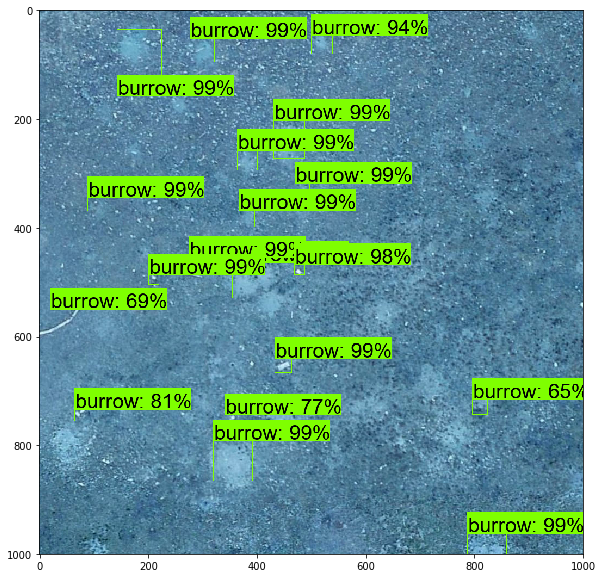

../data/images_test/6.jpg


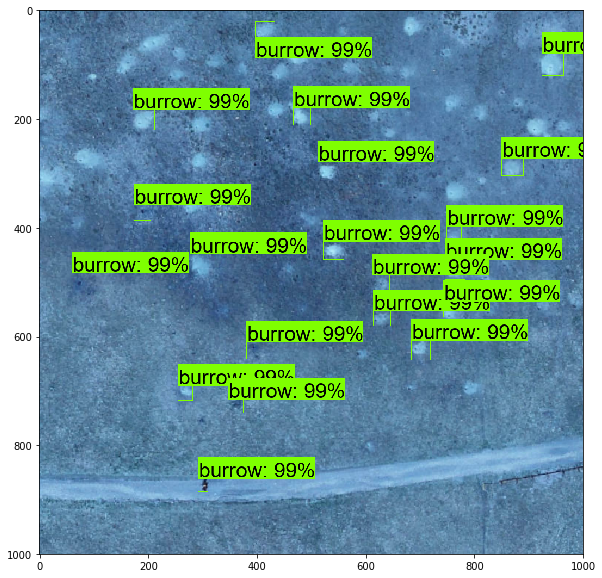

../data/images_test/2.jpg


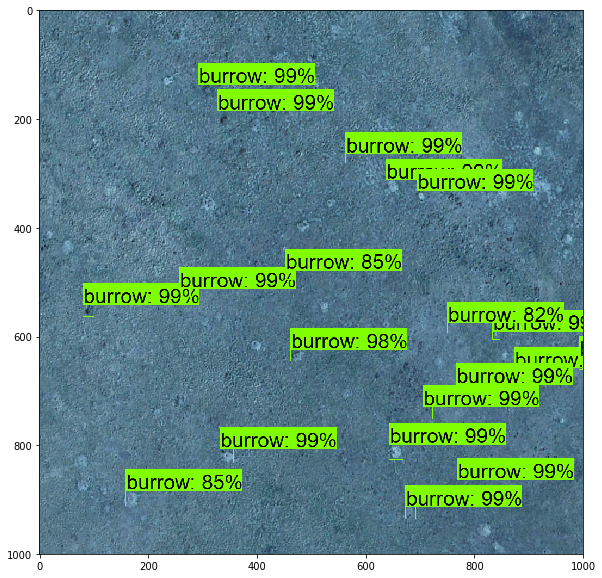

../data/images_test/3.jpg


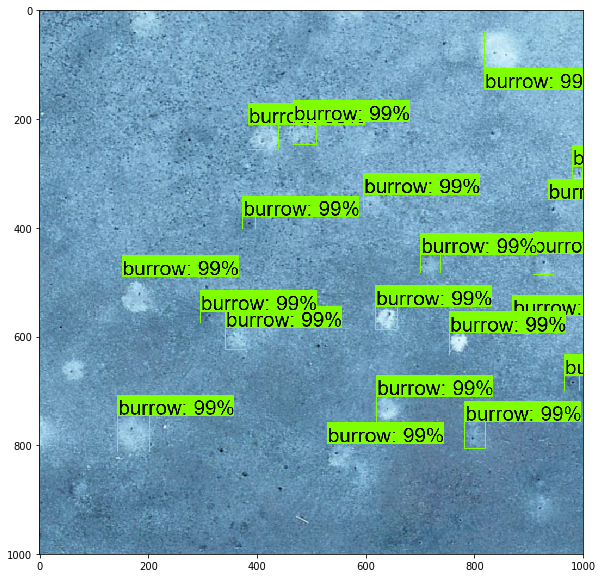

../data/images_test/1.jpg


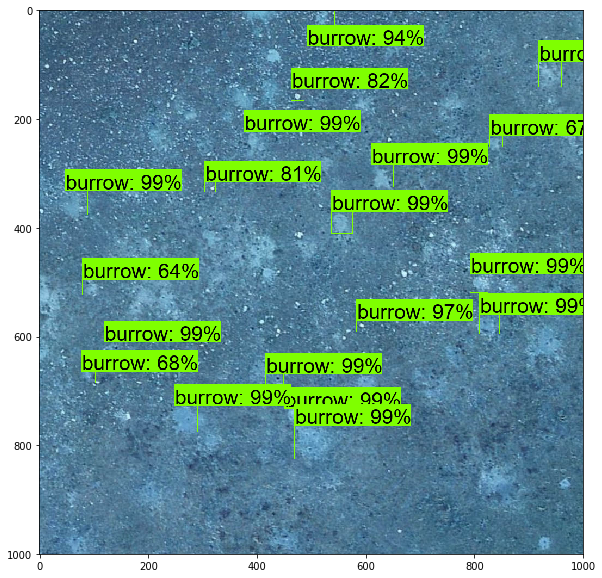

In [46]:
for image_path in TEST_IMAGE_PATHS:
  print(image_path)
  #image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  #image_np = load_image_into_numpy_array(image)
  image_np = cv2.imread(image_path,1)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  a = output_dict['detection_boxes']
  #print("shape of image=", image_np.shape)
  #print(output_dict['detection_boxes'])
  b = output_dict['detection_scores']
  #print([category_index.get(i)['name'] for i in output_dict['detection_classes']])
  #print(output_dict['detection_scores'])
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True, groundtruth_box_visualization_color='red',
      line_thickness=1)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.show()

plt.close('all')

In [47]:

'''
intersection_over_union(box1, box2)
params -> box1{list} is ground truth, box2{list} is predicted
returns -> IoU value
#credits -> https://gist.github.com/meyerjo/dd3533edc97c81258898f60d8978eddc
'''

def intersection_over_union(box1, box2):
    
    
    xmin, ymin, xmax, ymax = box1
    xmin_p, ymin_p, xmax_p, ymax_p = box2
    
    #print("box1=", box1)
    #print("box2=", box2)
    
    if (xmin > xmax) or (ymin > ymax):
        raise AssertionError("Ground truth coordinates are incorrect")
    
    if (xmin_p > xmax_p) or (ymin_p > ymax_p):
        raise AssertionError("Predicted box coordinates are incorrect")
    
    
    '''
    #if no overlap, return zero
    
    #If bottom right of x-coordinate  ground truth box is less than top left x coordinate of  the predicted box
    if x_max < xmin_p:
        return 0.0
    
    #If bottom right of y-coordinate ground truth box is greater than top left of y coordinate of predicted box
    if ymin > ymax_p:
        return 0.0
    
    #If top left of x-coordinate ground truth box is greater than bottom right of x coordinate of predicted box
    if xmax > xmax_p:
        return 0.0
    
    #If top left of y-coordinate ground truth box is less than bottom right of y coordinate of predicted box
    if y_max < ymax_p:
        return 0.0
     
    ''' 
    
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((box1[2] - box1[0]) * (box1[3] - box1[1]))
    boxBArea = abs((box2[2] - box2[0]) * (box2[3] - box2[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou
    
    
    
    

In [48]:
import xml.etree.ElementTree as ET
import pandas as pd

#define the csv file 
column_names = ["image_id", "ground_truth", "predicted", "IOU", "confidence"]
df = pd.DataFrame(columns= column_names)


#find paths to tagged test and corresponding xml files
PATH_TO_TEST_XML_DIR = '../data/tagged_test/'
xml_file_list = os.listdir(PATH_TO_TEST_XML_DIR)
#print(xml_file_list)
PATH_TO_TEST_IMAGES_DIR = '../data/images_test/'
image_file_list = os.listdir(PATH_TO_TEST_IMAGES_DIR)
#print(image_file_list)


#minimum score threshold as initialized from object_detection/utils/visualization_utils.py
min_score_thresh = 0.2

for image_name in image_file_list:
    
    #print(image_name)
    corresponding_xml_name_substring = image_name[:image_name.find('.jpg')]
   
    
    PATH_TO_TEST_IMAGE_FILE = PATH_TO_TEST_IMAGES_DIR + image_name
    PATH_TO_TEST_XML_FILE = PATH_TO_TEST_XML_DIR + corresponding_xml_name_substring + '.xml'
    
    
    root = ET.parse(PATH_TO_TEST_XML_FILE).getroot()
    width = int(root.find('size')[0].text)
    height = int(root.find('size')[1].text)

    
    #ground truth, an array of array of ground truth from the xml file where each elem ->  ["xmin","ymin", "xmax", "ymax"]
    ground_truth = []
    
    for obj in root.findall('object'):
         xmin = int(obj.find('bndbox')[0].text)
         ymin = int(obj.find('bndbox')[1].text)
         xmax = int(obj.find('bndbox')[2].text)
         ymax = int(obj.find('bndbox')[3].text)
         #xmin, ymin, xmax, ymax
         ground_truth.append([xmin, ymin, xmax, ymax])
         
    
    
    
    print(PATH_TO_TEST_IMAGE_FILE)
    #print("ground_truth=", ground_truth)
    image = Image.open(PATH_TO_TEST_IMAGE_FILE)
   
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    # image_np = load_image_into_numpy_array(image)
    
    image_np = cv2.imread(PATH_TO_TEST_IMAGE_FILE,1)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    boxes = output_dict['detection_boxes']
    scores = output_dict['detection_scores']
    
    
    
    #predicted_coord, an array of array of predicted coordinates from the TF graph where each elem ->  ["xmin_1","ymin_1", "xmax_1", "ymax_1"]
    predicted_coord = []
    for i in range(boxes.shape[0]):
      if scores is None or scores[i] > min_score_thresh:  
          box = tuple(boxes[i].tolist())
          
          #print("confidence=" , str(scores[i]))
          ymin, xmin, ymax, xmax = box
            
          #multiply with width and height since the above are normalized coordinates  
          (xmin_1, xmax_1, ymin_1, ymax_1) = (xmin * width, xmax * width, ymin * height, ymax * height)
           
          #xmin, ymin, xmax, ymax
          #print("predicted box =" , [xmin_1, ymin_1, xmax_1, ymax_1])
          predicted_coord.append([xmin_1, ymin_1, xmax_1, ymax_1])  
          #vis_util.draw_bounding_box_on_image_array(image_np, ymin_1, xmin_1, ymax_1, xmax_1, color='green', thickness = 2, use_normalized_coordinates = False)
          #plt.figure(figsize=IMAGE_SIZE)
          #plt.imshow(image_np)
          #plt.show()  
    
    
    
    
    #iterate through every predicted_coord and calculate Intersection over Union(IOU)
   
    for i in range(len(predicted_coord)):
        for j in range(len(ground_truth)):
            iou = intersection_over_union(ground_truth[j], predicted_coord[i])
            confidence = scores[i] * 100
            df = df.append({'image_id': PATH_TO_TEST_IMAGE_FILE, 'ground_truth':ground_truth[j], 'predicted':predicted_coord[i],'IOU':iou, 'confidence':confidence}, ignore_index=True)
            
            #print(ground_truth[j], predicted_coord[i], intersection_over_union(ground_truth[j], predicted_coord[i]))
           


../data/images_test/7.jpg
../data/images_test/6.jpg
../data/images_test/2.jpg
../data/images_test/3.jpg
../data/images_test/1.jpg


In [49]:
df

image_id           ground_truth  \
0     ../data/images_test/7.jpg    [139, 25, 203, 101]   
1     ../data/images_test/7.jpg    [279, 53, 324, 108]   
2     ../data/images_test/7.jpg   [236, 152, 273, 194]   
3     ../data/images_test/7.jpg     [501, 44, 530, 74]   
4     ../data/images_test/7.jpg   [442, 208, 480, 245]   
5     ../data/images_test/7.jpg   [372, 256, 411, 289]   
6     ../data/images_test/7.jpg   [440, 253, 477, 291]   
7     ../data/images_test/7.jpg   [467, 324, 502, 366]   
8     ../data/images_test/7.jpg   [361, 359, 394, 399]   
9     ../data/images_test/7.jpg   [351, 476, 398, 527]   
10    ../data/images_test/7.jpg   [399, 466, 438, 515]   
11    ../data/images_test/7.jpg   [401, 519, 448, 558]   
12    ../data/images_test/7.jpg   [173, 430, 205, 458]   
13    ../data/images_test/7.jpg    [74, 431, 109, 461]   
14    ../data/images_test/7.jpg   [327, 625, 381, 679]   
15    ../data/images_test/7.jpg     [20, 767, 75, 823]   
16    ../data/images_test/7.jpg   [288, 891, 324, 922]   
17    ../data/images_test/7.jpg   [312, 795, 397, 882]   
18    ../data/images_test/7.jpg   [421, 713, 478, 773]   
19    ../data/images_test/7.jpg   [80, 965, 128, 1000]   
20    ../data/images_test/7.jpg   [612, 528, 670, 588]   
21    ../data/images_test/7.jpg   [736, 744, 796, 807]   
22    ../data/images_test/7.jpg   [696, 661, 751, 714]   
23    ../data/images_test/7.jpg  [780, 966, 857, 1000]   
24    ../data/images_test/7.jpg     [885, 22, 919, 56]   
25    ../data/images_test/7.jpg   [796, 327, 832, 361]   
26    ../data/images_test/7.jpg  [985, 449, 1000, 487]   
27    ../data/images_test/7.jpg  [987, 274, 1000, 302]   
28    ../data/images_test/7.jpg   [493, 677, 520, 707]   
29    ../data/images_test/7.jpg   [282, 700, 318, 726]   
...                         ...                    ...   
8047  ../data/images_test/1.jpg   [358, 413, 435, 470]   
8048  ../data/images_test/1.jpg   [245, 727, 295, 775]   
8049  ../data/images_test/1.jpg   [292, 766, 337, 807]   
8050  ../data/images_test/1.jpg   [400, 801, 430, 828]   
8051  ../data/images_test/1.jpg   [176, 861, 217, 894]   
8052  ../data/images_test/1.jpg     [53, 961, 82, 997]   
8053  ../data/images_test/1.jpg   [437, 953, 485, 995]   
8054  ../data/images_test/1.jpg   [469, 763, 527, 828]   
8055  ../data/images_test/1.jpg   [456, 733, 487, 759]   
8056  ../data/images_test/1.jpg   [525, 668, 547, 690]   
8057  ../data/images_test/1.jpg   [585, 668, 626, 715]   
8058  ../data/images_test/1.jpg   [918, 966, 942, 993]   
8059  ../data/images_test/1.jpg   [851, 888, 872, 909]   
8060  ../data/images_test/1.jpg   [812, 837, 880, 885]   
8061  ../data/images_test/1.jpg   [816, 885, 836, 907]   
8062  ../data/images_test/1.jpg   [952, 859, 980, 884]   
8063  ../data/images_test/1.jpg   [909, 577, 969, 644]   
8064  ../data/images_test/1.jpg   [809, 558, 843, 596]   
8065  ../data/images_test/1.jpg   [751, 618, 785, 649]   
8066  ../data/images_test/1.jpg   [941, 514, 961, 534]   
8067  ../data/images_test/1.jpg   [617, 292, 656, 333]   
8068  ../data/images_test/1.jpg   [575, 153, 615, 189]   
8069  ../data/images_test/1.jpg   [821, 232, 851, 263]   
8070  ../data/images_test/1.jpg    [911, 96, 970, 142]   
8071  ../data/images_test/1.jpg  [965, 210, 1000, 270]   
8072  ../data/images_test/1.jpg   [692, 294, 719, 327]   
8073  ../data/images_test/1.jpg     [629, 40, 670, 92]   
8074  ../data/images_test/1.jpg   [735, 150, 794, 209]   
8075  ../data/images_test/1.jpg   [698, 554, 724, 577]   
8076  ../data/images_test/1.jpg   [796, 489, 827, 520]   

                                              predicted       IOU  confidence  
0     [320.2521800994873, 792.3316955566406, 392.630...         0   99.999928  
1     [320.2521800994873, 792.3316955566406, 392.630...         0   99.999928  
2     [320.2521800994873, 792.3316955566406, 392.630...         0   99.999928  
3     [320.2521800994873, 792.3316955566406, 392.630...         0   99.999928  
4     [320.2521800994873, 

In [50]:
df.to_csv('../data/results_' + YEAR + '.csv')

../data/images_test/7.jpg


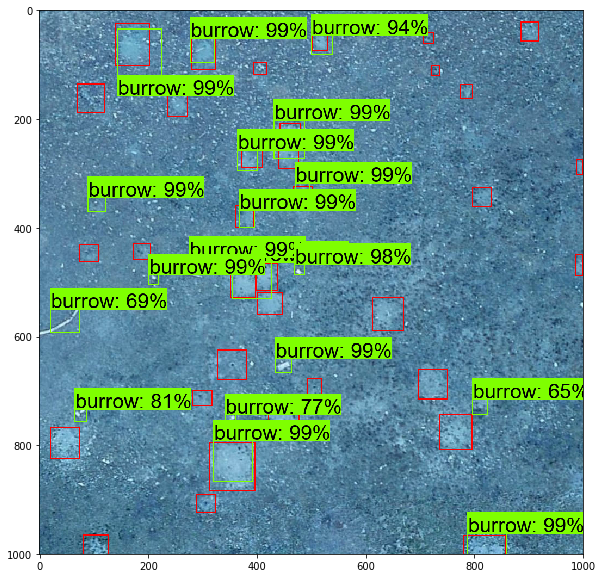

../data/images_test/6.jpg


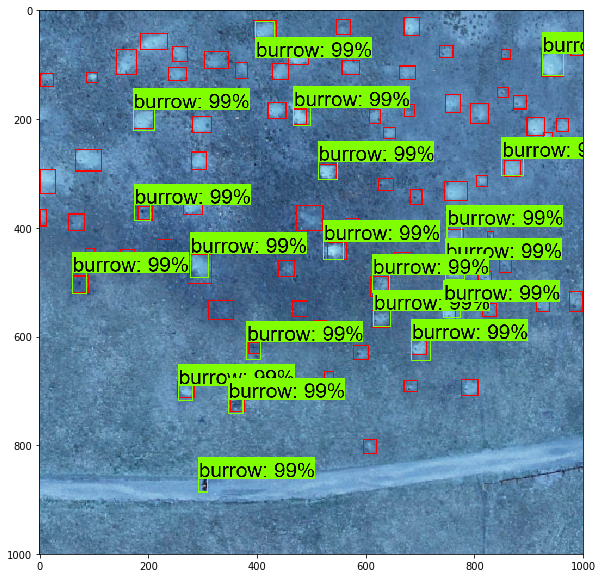

../data/images_test/2.jpg


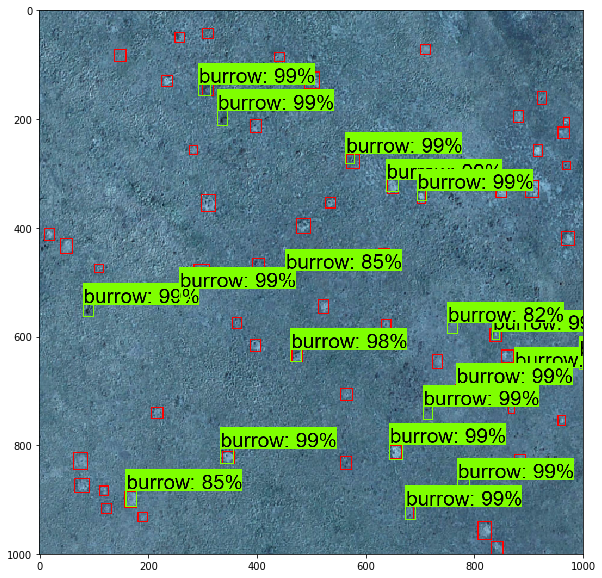

../data/images_test/3.jpg


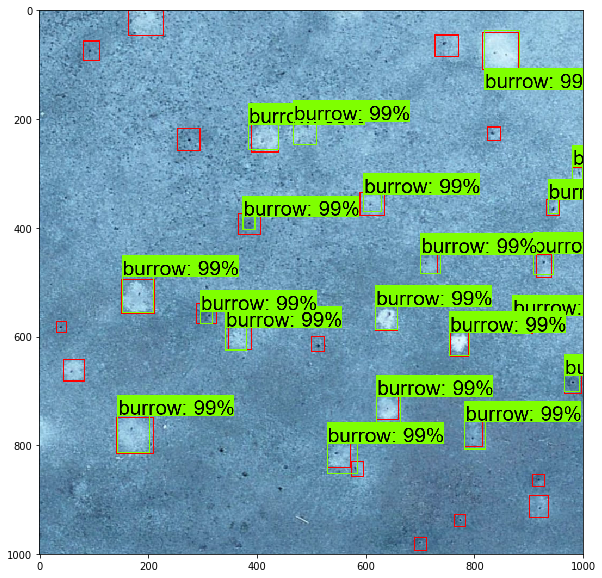

../data/images_test/1.jpg


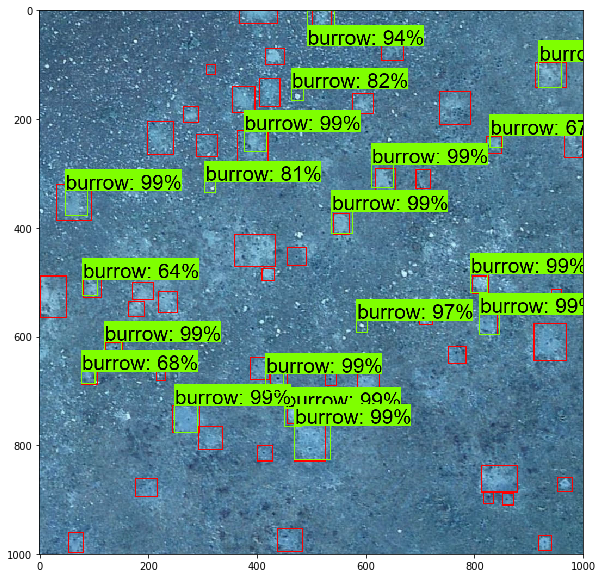

In [51]:
### VISUALIZE ALL TEST IMAGES ###


os.mkdir('../data/boxed_test_images/' + YEAR)


for image_name in image_file_list:
    
    #print(image_name)
    corresponding_xml_name_substring = image_name[:image_name.find('.jpg')]
   
    
    PATH_TO_TEST_IMAGE_FILE = PATH_TO_TEST_IMAGES_DIR + image_name
    PATH_TO_TEST_XML_FILE = PATH_TO_TEST_XML_DIR + corresponding_xml_name_substring + '.xml'
    
    
    root = ET.parse(PATH_TO_TEST_XML_FILE).getroot()
    width = int(root.find('size')[0].text)
    height = int(root.find('size')[1].text)

    
    #ground truth, an array of array of ground truth from the xml file where each elem ->  ["xmin","ymin", "xmax", "ymax"]
    ground_truth = []
    
    for obj in root.findall('object'):
         xmin = int(obj.find('bndbox')[0].text)
         ymin = int(obj.find('bndbox')[1].text)
         xmax = int(obj.find('bndbox')[2].text)
         ymax = int(obj.find('bndbox')[3].text)
         #xmin, ymin, xmax, ymax
         ground_truth.append([xmin, ymin, xmax, ymax])
         
    
    
    
    print(PATH_TO_TEST_IMAGE_FILE)
    image = Image.open(PATH_TO_TEST_IMAGE_FILE)
   
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    #image_np = load_image_into_numpy_array(image)
    
    image_np = cv2.imread(PATH_TO_TEST_IMAGE_FILE,1)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    boxes = output_dict['detection_boxes']
    scores = output_dict['detection_scores']
    
    
    
    #visualize ground truth
    for row in ground_truth:
        vis_util.draw_bounding_box_on_image_array(image_np, row[1], row[0], row[3], row[2], color='red', thickness = 2, use_normalized_coordinates = False)
    
    
    #visualize prediction
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.savefig('../data/boxed_test_images/' + YEAR + '/' + image_name)
    plt.show()
    
    
    
    

```` 
To-Do's
1. Add confidence level as col in csv
2. Remove bogus columns
3. https://drive.google.com/drive/u/1/folders/14Rzw0korpD1vL3BR69o4XYpkRqK0vSRk
````